In [1]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-01-29 16:16:05.437042: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 16:16:05.659094: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 16:16:05.659151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 16:16:05.692468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 16:16:05.769405: I tensorflow/core/platform/cpu_feature_guar

# Import library

In [2]:
from time import time
from timeit import default_timer as timer
from datetime import timedelta, datetime
import re
import os
import io
import pickle
import sys
import subprocess
from glob import glob
import csv
import math
import codecs
import copy
from tqdm import tqdm

# EDA
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import pandas as pd

# NLP & ML 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    matthews_corrcoef,
    cohen_kappa_score
)

# DL
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    InputSpec,
    Layer, 
    Input,
    Embedding, 
    Conv1D, 
    Conv2D, 
    Bidirectional, 
    Dense, 
    Attention,
    LSTM, 
    Activation, 
    Add, 
    Flatten, 
    Concatenate, 
    concatenate,
    Reshape, 
    Dropout, 
    SpatialDropout1D, 
    BatchNormalization,
    MaxPooling1D, 
    MaxPool2D, 
    GlobalAveragePooling1D, 
    GlobalMaxPooling1D, 
    GlobalMaxPool1D
)
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

2024-01-29 16:16:09.335439: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-29 16:16:09.363932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 16:16:09.363965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 16:16:09.364541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 16:16:09.368876: I tensorflow/core/platform/cpu_feature_guar

# Ploting code

In [33]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
#     from itertools import izip
    pc.update_scalarmappable()
    ax = pc.axes# FOR LATEST MATPLOTLIB
    
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      
    
    # save the figure
    plt.savefig('reports/' + title + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + title + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))
    

#
def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    
# Function to plot the training and validation loss and accuracy
def plot_loss_accuracy(history, model_name):
    # plot the training and validation loss
    plt.plot(history.epoch, history.history['loss'], '-o', label='Training_loss')
    plt.plot(history.epoch, history.history['val_loss'], '-o', label='Validation_loss')
    plt.title(model_name + ' model loss')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('reports/' + model_name + '_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + model_name + '_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    
    # plot the training and validation accuracy
    plt.plot(history.epoch, history.history['accuracy'], '-o', label='Training_accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], '-o', label='Validation_accuracy')
    plt.title(model_name + ' model accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.savefig('reports/' + model_name + '_accuracy' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + model_name + '_accuracy' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

def plot_class_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    ax = sns.countplot(x='label', data=data)
    ax.set_title(title)
    
    # Annotate the bars with the number of samples
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        
    plt.show()

# Datasets importation and EDA

In [ ]:
# import the train, validation and the test sets
print('Loading datasets...')
train_set= pd.read_csv('datasets/training_set.csv')
val_set = pd.read_csv('datasets/validation_set.csv')
test_set = pd.read_csv('datasets/test_set.csv')

# import all augmented dataset
train_set_ch = pd.read_csv('datasets/vishing_dataset_CH_AUG.csv')
train_set_en = pd.read_csv('datasets/vishing_dataset_EN_AUG.csv')
train_set_ja = pd.read_csv('datasets/vishing_dataset_JA_AUG.csv')

print('Datasets loaded.')

In [ ]:
train_set.info()
print('-'*80)
val_set.info()
print('-'*80)
test_set.info()

In [ ]:
train_set_en.info()
print('-'*80)
train_set_ja.info()
print('-'*80)
train_set_ch.info()

In [ ]:
# Delete all the rows in train_set_en, train_set_ja and train_set_ch that have label 0
train_set_ch = train_set_ch[train_set_ch['label'] != 0]
train_set_en = train_set_en[train_set_en['label'] != 0]
train_set_ja = train_set_ja[train_set_ja['label'] != 0]

## Plot the distribution of the classes in the datasets

In [ ]:
#plot the distribution of the datasets
plot_class_distribution(train_set, 'Train Dataset Class Distribution')
plot_class_distribution(val_set, 'Validation Dataset Class Distribution')
plot_class_distribution(test_set, 'Test Dataset Class Distribution')

In [ ]:
#plot the distribution of the datasets
plot_class_distribution(train_set_en, '(English Augmented) Train Dataset Class Distribution')
plot_class_distribution(train_set_ja, '(Japanese Augmented) Train Dataset Class Distribution')
plot_class_distribution(train_set_ch, '(Chinese Augmented) Train Dataset Class Distribution')

In [ ]:
# drop the colum we don't need
train_set.drop(['id'], axis=1, inplace=True)
val_set.drop(['id'], axis=1, inplace=True)
test_set.drop(['id'], axis=1, inplace=True)

#check the dataframes
train_set.info()
print('-'*80)
val_set.info()
print('-'*80)
test_set.info()

In [ ]:
# drop the colum we don't need
train_set_en.drop(['id', 'transcript', 'translation', 'processed'], axis=1, inplace=True)
train_set_ja.drop(['id', 'transcript', 'translation', 'processed'], axis=1, inplace=True)
train_set_ch.drop(['id', 'transcript', 'translation', 'processed'], axis=1, inplace=True)

#check the dataframes
train_set_en.info()
print('-'*80)
train_set_ja.info()
print('-'*80)
train_set_ch.info()

In [ ]:
# rename the column back_translation of train_set_en, train_set_ja, train_set_ch to transcript_en, transcript_ja, transcript_ch
train_set_en.rename(columns={'back_translation':'transcript_en'}, inplace=True)
train_set_ja.rename(columns={'back_translation':'transcript_ja'}, inplace=True)
train_set_ch.rename(columns={'back_translation':'transcript_ch'}, inplace=True)

# display the info of the dataframes
train_set_en.info()
print('-'*80)
train_set_ja.info()
print('-'*80)
train_set_ch.info()

 ## Calculating the length of each data sample.

In [ ]:
# calculate the length of each data sample in the train_set, val_set and test_set and add the length as a new column named length to the dataframes
train_set['length'] = train_set['transcript'].apply(lambda x: len(x))
val_set['length'] = val_set['transcript'].apply(lambda x: len(x))
test_set['length'] = test_set['transcript'].apply(lambda x: len(x))

In [ ]:
# display the heads of the train_set and sort the dataframe by length
train_set.head().sort_values(by=['length'], ascending=False)

In [ ]:
val_set.head().sort_values(by=['length'], ascending=False)

In [ ]:
test_set.head().sort_values(by=['length'], ascending=False)

In [ ]:
# calculate the length of each data samples in the train_set_en, train_set_ja and train_set_ch and add the length as a new column named length to the dataframes
train_set_en['length'] = train_set_en['transcript_en'].apply(lambda x: len(x))
train_set_ja['length'] = train_set_ja['transcript_ja'].apply(lambda x: len(x))
train_set_ch['length'] = train_set_ch['transcript_ch'].apply(lambda x: len(x))

In [ ]:
# display the heads of the train_set_en and sort the dataframe by length
train_set_en.head().sort_values(by=['length'], ascending=False)

In [ ]:
train_set_ja.head().sort_values(by=['length'], ascending=False)

In [ ]:
train_set_ch.head().sort_values(by=['length'], ascending=False)

## Distribution based on length of words

In [ ]:
# Make a function to plot the distribution of the length of the data samples in the train_set, val_set and test_set (boxplot and histogram)
def plot_length_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    
    # plot the boxplot
    # sns.boxplot(x='length', data=data, ax=ax1)
    sns.boxplot(y='length', x='label', data=data, ax=ax1)
    ax1.set_title('Boxplot')
    
    # plot the histogram
    sns.histplot(x='length', data=data, ax=ax2)
    ax2.set_title('Histogram')
    
    plt.show()

In [ ]:
# plot the distribution of the length of the data samples in the train_set, val_set and test_set
plot_length_distribution(train_set, 'Train Dataset Length Distribution')
plot_length_distribution(val_set, 'Validation Dataset Length Distribution')
plot_length_distribution(test_set, 'Test Dataset Length Distribution')

In [ ]:
# plot the distribution of the length of the data samples in the train_set_en, train_set_ja and train_set_ch
plot_length_distribution(train_set_en, '(English Augmented) Train Dataset Length Distribution')
plot_length_distribution(train_set_ja, '(Japanese Augmented) Train Dataset Length Distribution')
plot_length_distribution(train_set_ch, '(Chinese Augmented) Train Dataset Length Distribution')

## Concatenate the augmented datasets to the original train_set dataframe


In [ ]:
# Make new train_set dataset with only train_set['transcript'] and train_set['label'] columns.
train_set_new = train_set[['transcript', 'label']]
train_set_new.columns = ['transcript', 'label']
train_set_new

In [ ]:
# Make new train_set_en dataset with only train_set_en['transcript_en'] and train_set_en['label'] columns. Rename the columns to 'transcript_en' to 'transcript'.
train_set_en_new = train_set_en[['transcript_en', 'label']]
train_set_en_new.columns = ['transcript', 'label']
train_set_en_new

In [ ]:
# concatenate the augmented train_set_en dataset with the original dataset to create the new train_set dataset for training the models with back-translation method as text augmentation method.
train_set_EnKo = pd.concat([train_set_new, train_set_en_new], ignore_index=True)
train_set_EnKo = train_set_EnKo.sample(frac=1).reset_index(drop=True)
train_set_EnKo

In [ ]:
# plot the class distribution of the new train_set dataset 
plot_class_distribution(train_set_EnKo, 'En-Ko Augmented Train Set Class Distribution')

In [ ]:
# Make new train_set_ch dataset with only train_set_ch['transcript_ch'] and train_set_ch['label'] columns. Rename the columns to 'transcript_ch' to 'transcript'.
train_set_ch_new = train_set_ch[['transcript_ch', 'label']]
train_set_ch_new.columns = ['transcript', 'label']
train_set_ch_new

In [ ]:
# concatenate the augmented train_set_ch dataset with the original dataset to create the new train_set dataset for training the models with back-translation method as text augmentation method.
train_set_ChKo = pd.concat([train_set_new, train_set_ch_new], ignore_index=True)
train_set_ChKo = train_set_ChKo.sample(frac=1).reset_index(drop=True)
train_set_ChKo

In [ ]:
# plot the class distribution of the new train_set dataset
plot_class_distribution(train_set_ChKo, 'Ch-Ko Augmented Train Set Class Distribution')

In [ ]:
# Make new train_set_ja dataset with only train_set_ja['transcript_ja'] and train_set_ja['label'] columns. Rename the columns to 'transcript_ja' to 'transcript'.
train_set_ja_new = train_set_ja[['transcript_ja', 'label']]
train_set_ja_new.columns = ['transcript', 'label']
train_set_ja_new

In [ ]:
# concatenate the augmented train_set_ja dataset with the original dataset to create the new train_set dataset for training the models with back-translation method as text augmentation method.
train_set_JaKo = pd.concat([train_set_new, train_set_ja_new], ignore_index=True)
train_set_JaKo = train_set_JaKo.sample(frac=1).reset_index(drop=True)
train_set_JaKo

In [ ]:
# plot the class distribution of the new train_set dataset
plot_class_distribution(train_set_JaKo, 'Ja-Ko Augmented Train Set Class Distribution')

In [ ]:
# concatenate the augmented train_set_new, train_set_en_new, train_set_ch_new, train_set_ja_new dataset to a new dataset
train_set_all = pd.concat([train_set_new, train_set_en_new, train_set_ch_new, train_set_ja_new], ignore_index=True)
train_set_all = train_set_all.sample(frac=1).reset_index(drop=True)
train_set_all

In [ ]:
# plot the class distribution of the new train_set dataset
plot_class_distribution(train_set_all, 'All BT Augmented Train Set Class Distribution')

In [ ]:
# Save all the new train_set dataset to csv files
train_set_EnKo.to_csv('datasets/train_set_EnKo.csv', index=False)
train_set_ChKo.to_csv('datasets/train_set_ChKo.csv', index=False)
train_set_JaKo.to_csv('datasets/train_set_JaKo.csv', index=False)
train_set_all.to_csv('datasets/train_set_all.csv', index=False)

# Data Preprocessing

## Import all the train, validation and test sets

In [ ]:
# import the train, validation and the test sets
print('Loading datasets...')
train_set= pd.read_csv('datasets/training_set.csv')
val_set = pd.read_csv('datasets/validation_set.csv')
test_set = pd.read_csv('datasets/test_set.csv')

# import all augmented dataset
train_set_EnKo = pd.read_csv('datasets/train_set_EnKo.csv')
train_set_ChKo = pd.read_csv('datasets/train_set_ChKo.csv')
train_set_JaKo = pd.read_csv('datasets/train_set_JaKo.csv')
train_set_all = pd.read_csv('datasets/train_set_all.csv')

print('Datasets loaded.')

In [ ]:
# display the heads of the train_set, val_set and test_set
train_set.head()

In [ ]:
# in one figure, plot all the class distribution of all the augmented train_set dataset and original train_set dataset.
sns.set(style="whitegrid")
# sns.set(style="ticks")
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('All Train Set Class Distribution')

# plot the class distribution of the original train_set dataset
sns.countplot(x='label', data=train_set, ax=ax1)
ax1.set_title('Original Train Set')

# plot the class distribution of the En-Ko augmented train_set dataset
sns.countplot(x='label', data=train_set_EnKo, ax=ax2)
ax2.set_title('En-Ko Augmented Train Set')

# plot the class distribution of the Ch-Ko augmented train_set dataset
sns.countplot(x='label', data=train_set_ChKo, ax=ax3)
ax3.set_title('Ch-Ko Augmented Train Set')

# plot the class distribution of the Ja-Ko augmented train_set dataset
sns.countplot(x='label', data=train_set_JaKo, ax=ax4)
ax4.set_title('Ja-Ko Augmented Train Set')

# plot the class distribution of the All augmented train_set dataset
sns.countplot(x='label', data=train_set_all, ax=ax5)
ax5.set_title('All Augmented Train Set')

plt.show()


## Installation of mecab-ko and mecab-ko-dic for Korean text preprocessing, Morphology Analyzer

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [ ]:
cd Mecab-ko-for-Google-Colab

In [ ]:
!bash install_mecab-ko_on_colab_light_220429.sh

In [ ]:
# # Check if Mecab-ko-for-GoogleColab is installed. If not, install it.
# try:
#     from konlpy.tag import Mecab
# except:
#     print('Mecab-ko-for-GoogleColab is not installed. Installing...')
#     # subprocess.check_call(['bash', './install_mecab-ko_on_colab190912.sh'])
#     # print('Mecab-ko-for-GoogleColab installed.')
#     print('run the following command in the terminal: bash ./install_mecab-ko_on_colab190912.sh')
# 
# 
# # if not os.path.exists('/content/Mecab-ko-for-Google-Colab'):
# #     print('Installing Mecab-ko-for-Google-Colab...')
# #     !git clone

### Testing the Mecab-ko

In [ ]:
# Test the Mecab-ko
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
text = '네이버에 중고나라 사이트 아시죠? 대구지역 있으세요 아시죠? 사이트에서 김재원 일단...'
print(mecab.morphs(text))
print(mecab.pos(text))
print(mecab.nouns(text))

### Dataset cleaning and purification

In [ ]:
# functions to perform the cleaning parts
def apply_replacement(src_df, replace_func):
    # Create a copy of the DataFrame to avoid modifying the original one
    ret_df = src_df.copy()
    
    # Apply the replacement function to each element in the 'transcript_cleaned' column
    ret_df.loc[:, 'transcript_cleaned'] = ret_df['transcript_cleaned'].apply(replace_func)
    # ret_df['transcript_cleaned'] = ret_df['transcript_cleaned'].apply(lambda x: replace_func(x))
    
    return ret_df

# remove the unwanted word and characters from the dataset
def word_replace(x):
    example_word_replace_list = {'o/': '',
                                 'b/': '',
                                 'n/': '',
                                 '\n': ' ',
                                 'name': '',
                                 'laughing': '',
                                 'clearing': '',
                                 'singing': '',
                                 'applauding': ''}
    for i in example_word_replace_list:
        x = x.replace(i, example_word_replace_list[i])
    return x

# remove the special character from the transcripts
# def remove_special_symbols(sentence):
#     sentence = re.sub(r"[^a-zA-Z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]", '', sentence)
#     return sentence

def remove_special_symbols(sentence): 
    sentence = re.sub(r"[-~=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", '', sentence)
    return sentence

# Function to delete placeholder words like X, x, O, o, ㅇ, 0, O, o that are repeated more than 2 times in a row
def replace_x_o(sentence):
    sentence = re.sub(r"([xXoOㅇ0]{2,})", '', sentence)
    return sentence

# remove the unwanted word and characters from the transcripts
def nline_replace(x):
    example_word_replace_list = {'\n' : ' '}
    for i in example_word_replace_list:
        x = x.replace(i, example_word_replace_list[i])
    return x

# Function to delete extra white space between words
def remove_extra_white_spaces(sentence):
    sentence = re.sub(r"\s+", ' ', sentence)
    return sentence

# def remove_extra_white_spaces(text):
#     single_char_pattern = r'\s+[a-zA-Z]\s+'
#     without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
#     return without_sc

# Function to delete all the numbers and digits from the transcripts
def remove_numbers(sentence):
    sentence = re.sub(r"\d+", '', sentence)
    return sentence

# A function to perform the cleaning parts on the dataset after duplicating the column transcript to transcript_cleaned and put it next to the original column transcript
def clean_dataset(dataset):
    # duplicate the original transcript to keep track of the processing
    dataset['transcript_cleaned'] = dataset['transcript']
    
    # move the column transcript_cleaned next to the original column transcript
    dataset = dataset[['transcript', 'transcript_cleaned', 'label']]
    
    # apply the cleaning functions to the dataset
    dataset = apply_replacement(dataset, word_replace)
    dataset = apply_replacement(dataset, remove_special_symbols)
    dataset = apply_replacement(dataset, replace_x_o)
    dataset = apply_replacement(dataset, nline_replace)
    dataset = apply_replacement(dataset, remove_extra_white_spaces)
    dataset = apply_replacement(dataset, remove_numbers)
    return dataset

In [ ]:
# clean the train_set, val_set and test_set and save them in a new column named transcript_cleaned next to the original column transcript in the dataframes.
train_set = clean_dataset(train_set)
val_set = clean_dataset(val_set)
test_set = clean_dataset(test_set)

In [ ]:
# display the heads of the train_set, val_set and test_set
train_set.head()

In [ ]:
val_set.head()

In [ ]:
test_set.head()

In [ ]:
# clean the train_set_EnKo, train_set_ChKo, train_set_JaKo and train_set_all
train_set_EnKo = clean_dataset(train_set_EnKo)
train_set_ChKo = clean_dataset(train_set_ChKo)
train_set_JaKo = clean_dataset(train_set_JaKo)
train_set_all = clean_dataset(train_set_all)

In [ ]:
# display the heads of the train_set_EnKo, train_set_ChKo, train_set_JaKo and train_set_all
train_set_EnKo.head()

In [ ]:
train_set_ChKo.head()

In [ ]:
train_set_JaKo.head()

In [ ]:
train_set_all.head()

In [ ]:
# # add a column named length to the datasets and calculate the length of each transcript_cleaned and add it to the length column
# train_set['length'] = train_set['transcript_cleaned'].apply(lambda x: len(x))
# val_set['length'] = val_set['transcript_cleaned'].apply(lambda x: len(x))
# test_set['length'] = test_set['transcript_cleaned'].apply(lambda x: len(x))
# 
# train_set_EnKo['length'] = train_set_EnKo['transcript_cleaned'].apply(lambda x: len(x))
# train_set_ChKo['length'] = train_set_ChKo['transcript_cleaned'].apply(lambda x: len(x))
# train_set_JaKo['length'] = train_set_JaKo['transcript_cleaned'].apply(lambda x: len(x))
# train_set_all['length'] = train_set_all['transcript_cleaned'].apply(lambda x: len(x))

### Remove the stopwords from the transcripts
we will use the stopwords-ko-simple.txt file to remove the stopwords from the transcripts.It contains few stopwords that are commonly used in Korean language.
We will further use the stopwords-ko.txt file to remove the stopwords from the transcripts. It contains more stopwords than the stopwords-ko-simple.txt file.

In [ ]:
# import the stopwords from the file stopwords-ko-simple.txt and create a list of stopwords
def import_stopwords(file_name):    
    stopwords = []
    with open(file_name, 'r', encoding='utf-8') as f:
        for line in f:
            stopwords.append(line.strip())

    print(stopwords)
    
    return stopwords

In [ ]:
# using the function, import the stopwords from the file stopwords-ko-simple.txt
stopwords = import_stopwords('stopwords-ko-simple.txt')

In [ ]:
# # korean stopwords list
# stopwords = ["을", "를", "이", "가", "ㅡ", "은", "는", "XXX", "xxx", "어요", "아니", "입니다", "에서", "에서", "니까", "으로", "근데", "습니다", "습니까", "저희", "합니다", "하고", "싶어요", "있는", "있습니다", "싶습니다", "그냥", "고요", "에요", "예요", "으시", "그래서"]

# Function to remove the stop word from the train and test dataframe
def get_model_input(_words):
    global stopwords
    _words = [x for x in _words if x[0] not in stopwords]
    _words = [x for x in _words if x[:-1] not in stopwords]

    for i in range(len(_words)-1):
        yield _words[i]
        
def get_corpus(df):
    corpus = []
    for lwords in df:    
        temp = []
        for x in get_model_input(lwords):
            if len(x) != 1:
                temp.append("{}".format(x))
        corpus.append(" ".join(temp))
    return corpus 

In [ ]:
# remove the stopwords from the train_set, val_set, test_set, train_set_EnKo, train_set_ChKo, train_set_JaKo and train_set_all after tokenization with Mecab-ko
# train_set['transcript_cleaned00'] = train_set['transcript_cleaned'].apply(lambda x: ' '.join([word for word in mecab.morphs(x) if word not in (stopwords)]))
# val_set['transcript_cleaned'] = val_set['transcript_cleaned'].apply(lambda x: ' '.join([word for word in mecab.morphs(x) if word not in (stopwords)]))
# test_set['transcript_cleaned'] = test_set['transcript_cleaned'].apply(lambda x: ' '.join([word for word in mecab.morphs(x) if word not in (stopwords)]))

In [ ]:
# train_set_EnKo['transcript_cleaned'] = train_set_EnKo['transcript_cleaned'].apply(lambda x: ' '.join([word for word in mecab.morphs(x) if word not in (stopwords)]))
# train_set_ChKo['transcript_cleaned'] = train_set_ChKo['transcript_cleaned'].apply(lambda x: ' '.join([word for word in mecab.morphs(x) if word not in (stopwords)]))
# train_set_JaKo['transcript_cleaned'] = train_set_JaKo['transcript_cleaned'].apply(lambda x: ' '.join([word for word in mecab.morphs(x) if word not in (stopwords)]))
# train_set_all['transcript_cleaned'] = train_set_all['transcript_cleaned'].apply(lambda x: ' '.join([word for word in mecab.morphs(x) if word not in (stopwords)]))

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

train_set_corpus = get_corpus([(mecab.morphs(x)) for x in train_set['transcript_cleaned']])
val_set_corpus = get_corpus([(mecab.morphs(x)) for x in val_set['transcript_cleaned']])
test_set_corpus = get_corpus([(mecab.morphs(x)) for x in test_set['transcript_cleaned']])

In [ ]:
train_set_EnKo_corpus = get_corpus([(mecab.morphs(x)) for x in train_set_EnKo['transcript_cleaned']])
train_set_ChKo_corpus = get_corpus([(mecab.morphs(x)) for x in train_set_ChKo['transcript_cleaned']])
train_set_JaKo_corpus = get_corpus([(mecab.morphs(x)) for x in train_set_JaKo['transcript_cleaned']])
train_set_all_corpus = get_corpus([(mecab.morphs(x)) for x in train_set_all['transcript_cleaned']])

In [ ]:
# adding the corpus to the dataframe
train_set['corpus'] = train_set_corpus
val_set['corpus'] = val_set_corpus
test_set['corpus'] = test_set_corpus

train_set_EnKo['corpus'] = train_set_EnKo_corpus
train_set_ChKo['corpus'] = train_set_ChKo_corpus
train_set_JaKo['corpus'] = train_set_JaKo_corpus
train_set_all['corpus'] = train_set_all_corpus

In [ ]:
# add the length of the transcripts, transcript_cleaned and corpus to the dataframes
train_set['length'] = train_set['transcript'].apply(lambda x: len(x))
val_set['length'] = val_set['transcript'].apply(lambda x: len(x))
test_set['length'] = test_set['transcript'].apply(lambda x: len(x))

train_set_EnKo['length'] = train_set_EnKo['transcript'].apply(lambda x: len(x))
train_set_ChKo['length'] = train_set_ChKo['transcript'].apply(lambda x: len(x))
train_set_JaKo['length'] = train_set_JaKo['transcript'].apply(lambda x: len(x))
train_set_all['length'] = train_set_all['transcript'].apply(lambda x: len(x))

train_set['length_cleaned'] = train_set['transcript_cleaned'].apply(lambda x: len(x))
val_set['length_cleaned'] = val_set['transcript_cleaned'].apply(lambda x: len(x))
test_set['length_cleaned'] = test_set['transcript_cleaned'].apply(lambda x: len(x))

train_set_EnKo['length_cleaned'] = train_set_EnKo['transcript_cleaned'].apply(lambda x: len(x))
train_set_ChKo['length_cleaned'] = train_set_ChKo['transcript_cleaned'].apply(lambda x: len(x))
train_set_JaKo['length_cleaned'] = train_set_JaKo['transcript_cleaned'].apply(lambda x: len(x))
train_set_all['length_cleaned'] = train_set_all['transcript_cleaned'].apply(lambda x: len(x))

train_set['length_corpus'] = train_set['corpus'].apply(lambda x: len(x))
val_set['length_corpus'] = val_set['corpus'].apply(lambda x: len(x))
test_set['length_corpus'] = test_set['corpus'].apply(lambda x: len(x))

train_set_EnKo['length_corpus'] = train_set_EnKo['corpus'].apply(lambda x: len(x))
train_set_ChKo['length_corpus'] = train_set_ChKo['corpus'].apply(lambda x: len(x))
train_set_JaKo['length_corpus'] = train_set_JaKo['corpus'].apply(lambda x: len(x))
train_set_all['length_corpus'] = train_set_all['corpus'].apply(lambda x: len(x))

In [ ]:
train_set.head()

In [ ]:
train_set.head()

In [ ]:
train_set_all.head()

In [ ]:
# using the function, import the stopwords from the file stopwords-ko-simple.txt
stopwords = import_stopwords('stopwords-ko.txt')

In [ ]:
train_set_corpus_1 = get_corpus([(mecab.morphs(x)) for x in train_set['transcript_cleaned']])
val_set_corpus_1 = get_corpus([(mecab.morphs(x)) for x in val_set['transcript_cleaned']])
test_set_corpus_1 = get_corpus([(mecab.morphs(x)) for x in test_set['transcript_cleaned']])

train_set_EnKo_corpus_1 = get_corpus([(mecab.morphs(x)) for x in train_set_EnKo['transcript_cleaned']])
train_set_ChKo_corpus_1 = get_corpus([(mecab.morphs(x)) for x in train_set_ChKo['transcript_cleaned']])
train_set_JaKo_corpus_1 = get_corpus([(mecab.morphs(x)) for x in train_set_JaKo['transcript_cleaned']])
train_set_all_corpus_1 = get_corpus([(mecab.morphs(x)) for x in train_set_all['transcript_cleaned']])

In [ ]:
# adding the corpus to the dataframe
train_set['corpus_1'] = train_set_corpus_1
val_set['corpus_1'] = val_set_corpus_1
test_set['corpus_1'] = test_set_corpus_1

train_set_EnKo['corpus_1'] = train_set_EnKo_corpus_1
train_set_ChKo['corpus_1'] = train_set_ChKo_corpus_1
train_set_JaKo['corpus_1'] = train_set_JaKo_corpus_1
train_set_all['corpus_1'] = train_set_all_corpus_1

In [ ]:
# adding the length of corpus_1 to the dataframe 
train_set['length_corpus_1'] = train_set['corpus_1'].apply(lambda x: len(x))
val_set['length_corpus_1'] = val_set['corpus_1'].apply(lambda x: len(x))
test_set['length_corpus_1'] = test_set['corpus_1'].apply(lambda x: len(x))

train_set_EnKo['length_corpus_1'] = train_set_EnKo['corpus_1'].apply(lambda x: len(x))
train_set_ChKo['length_corpus_1'] = train_set_ChKo['corpus_1'].apply(lambda x: len(x))
train_set_JaKo['length_corpus_1'] = train_set_JaKo['corpus_1'].apply(lambda x: len(x))
train_set_all['length_corpus_1'] = train_set_all['corpus_1'].apply(lambda x: len(x))

In [ ]:
train_set.head()

In [ ]:
# order the columns in the dataframes to have the label column after the corpus column
train_set = train_set[['transcript', 'transcript_cleaned', 'corpus', 'corpus_1', 'label', 'length', 'length_cleaned', 'length_corpus', 'length_corpus_1']]
val_set = val_set[['transcript', 'transcript_cleaned', 'corpus', 'corpus_1', 'label', 'length', 'length_cleaned', 'length_corpus', 'length_corpus_1']]
test_set = test_set[['transcript', 'transcript_cleaned', 'corpus', 'corpus_1', 'label', 'length', 'length_cleaned', 'length_corpus', 'length_corpus_1']]

train_set_EnKo = train_set_EnKo[['transcript', 'transcript_cleaned', 'corpus', 'corpus_1', 'label', 'length', 'length_cleaned', 'length_corpus', 'length_corpus_1']]
train_set_ChKo = train_set_ChKo[['transcript', 'transcript_cleaned', 'corpus', 'corpus_1', 'label', 'length', 'length_cleaned', 'length_corpus', 'length_corpus_1']]
train_set_JaKo = train_set_JaKo[['transcript', 'transcript_cleaned', 'corpus', 'corpus_1', 'label', 'length', 'length_cleaned', 'length_corpus', 'length_corpus_1']]
train_set_all = train_set_all[['transcript', 'transcript_cleaned', 'corpus', 'corpus_1', 'label', 'length', 'length_cleaned', 'length_corpus', 'length_corpus_1']]

In [ ]:
train_set.head()

In [ ]:
train_set_all.head()

### Save the datasets to csv files

In [ ]:
# save all the dataframes to csv files
train_set.to_csv('datasets/train_set_ready.csv', index=False)
val_set.to_csv('datasets/val_set_ready.csv', index=False)
test_set.to_csv('datasets/test_set_ready.csv', index=False)

train_set_EnKo.to_csv('datasets/train_set_EnKo_ready.csv', index=False)
train_set_ChKo.to_csv('datasets/train_set_ChKo_ready.csv', index=False)
train_set_JaKo.to_csv('datasets/train_set_JaKo_ready.csv', index=False)
train_set_all.to_csv('datasets/train_set_all_ready.csv', index=False)

## Vectorization of the datasets
Encoding the text data into numerical data for the deep learning models

In [4]:
#load the datasets
print('Loading datasets...')
train_set= pd.read_csv('datasets/train_set_ready.csv')
val_set = pd.read_csv('datasets/val_set_ready.csv')
test_set = pd.read_csv('datasets/test_set_ready.csv')

# import all augmented dataset
train_set_EnKo = pd.read_csv('datasets/train_set_EnKo_ready.csv')
train_set_ChKo = pd.read_csv('datasets/train_set_ChKo_ready.csv')
train_set_JaKo = pd.read_csv('datasets/train_set_JaKo_ready.csv')
train_set_all = pd.read_csv('datasets/train_set_all_ready.csv')

print('Datasets loaded.')

Loading datasets...
Datasets loaded.


In [7]:
# define the train and test sets data from the dataframes
X_train = train_set['corpus']
X_train_1 = train_set['corpus_1']
y_train = train_set['label']

X_val = val_set['corpus']
X_val_1 = val_set['corpus_1']
y_val = val_set['label']

X_test = test_set['corpus']
X_test_1 = test_set['corpus_1']
y_test = test_set['label']

X_train_EnKo = train_set_EnKo['corpus']
X_train_EnKo_1 = train_set_EnKo['corpus_1']
y_train_EnKo = train_set_EnKo['label']

X_train_ChKo = train_set_ChKo['corpus']
X_train_ChKo_1 = train_set_ChKo['corpus_1']
y_train_ChKo = train_set_ChKo['label']

X_train_JaKo = train_set_JaKo['corpus']
X_train_JaKo_1 = train_set_JaKo['corpus_1']
y_train_JaKo = train_set_JaKo['label']

X_train_all = train_set_all['corpus']
X_train_all_1 = train_set_all['corpus_1']
y_train_all = train_set_all['label']

In [8]:
# Function to define the maximum number of words to be used
def max_words_func(X_train, X_val, X_test):
    max_len = 0
    max_words = 0
    
    # check the length of the trainset, the valset and the testset
    print('Train set size = {} \nValidation set size = {} \nTest set size = {}'.format(len(X_train), len(X_val), len(X_test)))
    
    # count the maximum number of words in the trainset
    max_words = len(set(" ".join(X_train).split())) # max number of words for tokenizer
    print('Maximum number of words in the train set = {}'.format(max_words))
    
    # get the maximum length of the sentences in the trainset
    max_len = max([len(x.split()) for x in X_train]) # max length of each sentences, including padding
    print('Maximum length of a sentence in the train set = {}'.format(max_len))

    return max_words, max_len

In [9]:
# define the maximum number of words and the maximum length of the sentences in the trainset
max_words, max_len = max_words_func(X_train, X_val, X_test)

Train set size = 2047 
Validation set size = 440 
Test set size = 440
Maximum number of words in the train set = 33844
Maximum length of a sentence in the train set = 4715


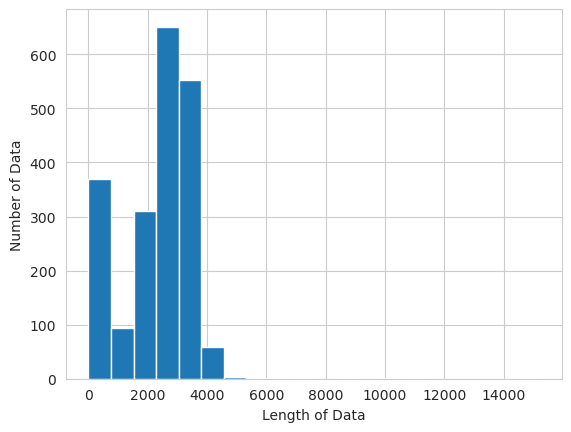

In [12]:
plt.hist([len(s) for s in X_train], bins=20)
plt.xlabel('Length of Data')
plt.ylabel('Number of Data')
plt.show()

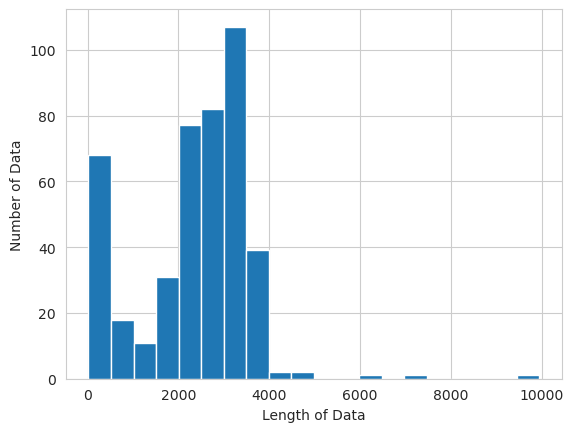

In [13]:
plt.hist([len(s) for s in X_test], bins=20)
plt.xlabel('Length of Data')
plt.ylabel('Number of Data')
plt.show()

### Traininig with the original train_set dataset

In [17]:
# Function to tokenize the text data
def tokenize_text(X_train, X_val, X_test, max_words=max_words, max_len=max_len):
    # define the tokenizer and tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=False, char_level=False)
    tokenizer.fit_on_texts(X_train)  #leaky
    
    # Function to convert texts to sequences of integers
    def texts_to_sequences(X_train, X_val, X_test):
        # convert texts to sequences of integers
        X_train_seq = tokenizer.texts_to_sequences(X_train)
        X_val_seq = tokenizer.texts_to_sequences(X_val)
        X_test_seq = tokenizer.texts_to_sequences(X_test)
        word_index = tokenizer.word_index
        
        print("Dictionary size: ", len(word_index))
        
        return X_train_seq, X_val_seq, X_test_seq, word_index
    
    # define the sequences of integers
    X_train_seq, X_val_seq, X_test_seq, word_index = texts_to_sequences(X_train, X_val, X_test)
    
    # FPad the sequences to ensure uniform length
    X_train_pad = pad_sequences(X_train_seq, padding='pre', maxlen=max_len)
    X_val_pad = pad_sequences(X_val_seq, padding='pre', maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, padding='pre', maxlen=max_len)
    
    return X_train_pad, X_val_pad, X_test_pad, word_index

In [18]:
# tokenize the text data
X_train_pad, X_val_pad, X_test_pad, word_index = tokenize_text(X_train, X_val, X_test, max_words, max_len)

Dictionary size:  33844


In [19]:
# encoding the data to numerical data
# define the tokenizer and tokenization
# tokenizer = Tokenizer(num_words=max_words, lower=False, char_level=False)
# tokenizer.fit_on_texts(X_train)  #leaky

In [20]:
# # Function to convert texts to sequences of integers
# def texts_to_sequences(X_train, X_val, X_test):
#     # convert texts to sequences of integers
#     X_train_seq = tokenizer.texts_to_sequences(X_train)
#     X_val_seq = tokenizer.texts_to_sequences(X_val)
#     X_test_seq = tokenizer.texts_to_sequences(X_test)
#     word_index = tokenizer.word_index
#     
#     print("Dictionary size: ", len(word_index))
#     
#     return X_train_seq, X_val_seq, X_test_seq, word_index

In [21]:
# define the sequences of integers
# X_train_seq, X_val_seq, X_test_seq, word_index = texts_to_sequences(X_train, X_val, X_test)

# Model Building and Training

## Importing the FastText word embeddings

In [47]:
# run if the wiki.ko.vec is not available in the same directory
import os
import urllib.request
# check if the file wiki.ko.vec is in the directory if not download it
if not os.path.isfile('wiki.ko.vec'):
    print('wiki.ko.vec does not exist, downloading file from the internet')
    # download the FastText word embeddings and monitor the download progress bar with tqdm
    with tqdm(unit='B', unit_scale=True, miniters=1, desc='wiki.ko.vec') as t:
        urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ko.vec', 'wiki.ko.vec', reporthook=lambda a,b,c: t.update(c))
    # urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ko.vec', 'wiki.ko.vec')
else:
    print('wiki.ko.vec exists, will not download file from the internet')

In [48]:
# import the FastText word embeddings
print('Loading word FastText embeddings...')
embeddings_index = {}
f = codecs.open('wiki.ko.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [51]:
print('Found %s word vectors' % len(embeddings_index))

In [54]:
print(len(embeddings_index))

In [ ]:
# # create a weight matrix for words in training docs
# embedding_matrix = np.zeros((max_words, embedding_dim))
# for word, i in word_index.items():
#     if i < max_words:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector

In [ ]:
# # define the embedding layer
# embedding_layer = Embedding(max_words,
#                             embedding_dim,
#                             embeddings_initializer=Constant(embedding_matrix),
#                             input_length=max_len,
#                             trainable=False)

In [23]:
# define the preprocessing parameters
embedding_dim = 300 # embedding dimensions for word vectors (word2vec/GloVe/Fasttext)

# defining the hyperparameters
learning_rate = 1e-3
batch_size= 32 # 64, 128
epochs = 10
steps_per_epoch = len(X_train) // batch_size  # total_samples is the training set size

# Calculating decay steps
# It's common to decay the learning rate at each epoch
decay_steps = steps_per_epoch * epochs # 10000
decay_rate = 0.9  # This is a common decay rate, but you can adjust it
# learning_decay = 1e-10 # 1e-4

spa_dropout_ratio = 0.2 # dropout ration, dropping a entire feature map
kernel_size = 3 # [1,2,3,5] # [1,2,3,5] Size of the kernel. Mixing kernels of various sizes.
                # specifying the length of the 1D convolution window.
dense_units = 64 # hidden unit 128 the number of neurons in the hidden layer
dropout_ratio = 0.2 # 0.1, 0.2 to 0.5 Dropout Ratio
num_filters = 50 # 36, 128, 256 number of kernels, conv_size
                # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

lstm_units_1 = 64 # the size(dim) of the hidden state vector as well as the output vector.
lstm_units_2 = 32 # the size(dim) of the hidden state vector as well as the output vector.

### Preparing FastText embedding matrix for future use

In [ ]:
#embedding matrix
# print('Preparing embedding matrix for future use...')
words_not_found = []
embed_dim = embedding_dim #300 # 32 Dimensions of the embedding vector
nb_words = min(max_words, len(word_index))
embedding_matrix = np.zeros((max_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

In [22]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])
df_results

,F1_score,Precision,Recall,Accuracy,Training time


## Training with default embedding layer and the original train_set dataset

### Single LSTM layer

In [50]:
# write a function to build, train and evaluate the LSTM model
def build_train_singlelstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(LSTM(lstm_units_1))
    model.add(Dense(dense_units, activation='relu'))
    # model.add(LSTM(lstm_units_1, dropout=dropout_ratio, recurrent_dropout=dropout_ratio))
    model.add(Dropout(spa_dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/singleLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='min'
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    print(confusion_matrix(y_test, y_pred))
        
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [25]:
# build, train and evaluate the LSTM model
model_1, history_1, report_1 = build_train_singlelstm_model('singleLSTM', X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

2024-01-29 18:01:22.350125: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 18:01:23.314240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 18:01:23.314311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 18:01:23.332577: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 18:01:23.332651: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4715, 300)         10153200  
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 10246705 (39.09 MB)
Trainable params: 93505 (365.25 KB)
Non-trainable params: 10153200 (38.73 MB)
_________________________________________________________________


2024-01-29 18:01:25.544490: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-29 18:01:25.550703: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-29 18:01:25.550818: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-29 18:01:25.550947: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-29 18:01:25.552081: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-29

None
######################################################################################################################################################
Epoch 1/10


2024-01-29 18:01:25.930241: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-29 18:01:25.930300: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-29 18:01:25.930644: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-29 18:01:25.930727: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-29 18:01:25.931275: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-29

64/64 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8188
Epoch 1: val_accuracy improved from inf to 0.98182, saving model to models/singleLSTM_20240129_180125.h5


/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 22s 315ms/step - loss: 0.3620 - accuracy: 0.8188 - val_loss: 0.1360 - val_accuracy: 0.9818
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9511
Epoch 2: val_accuracy improved from 0.98182 to 0.89091, saving model to models/singleLSTM_20240129_180125.h5
64/64 [==============================] - 20s 310ms/step - loss: 0.2752 - accuracy: 0.9511 - val_loss: 0.5965 - val_accuracy: 0.8909
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.9766
Epoch 3: val_accuracy did not improve from 0.89091
64/64 [==============================] - 18s 274ms/step - loss: 0.1581 - accuracy: 0.9766 - val_loss: 0.1144 - val_accuracy: 0.9705
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9868
Epoch 4: val_accuracy did not improve from 0.89091
64/64 [==============================] - 16s 253ms/step - loss: 0.0813 - accuracy: 0.9868 - val_loss: 0.1035 - 

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
singleLSTM,0.995215,1.0,0.990476,0.997727,171.446539


#### Plot the results

[0.997, 1.0, 0.9985]
[1.0, 0.9905, 0.9952]
plotMat: [[0.997, 1.0, 0.9985], [1.0, 0.9905, 0.9952]]
support: [335, 105]


TypeError: Only length-1 arrays can be converted to Python scalars

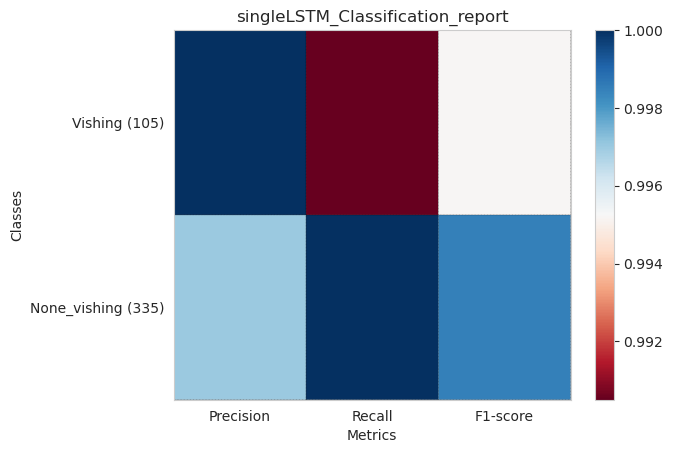

In [34]:
plot_classification_report(report_1, 'singleLSTM_Classification_report')

In [28]:
# plt.savefig('reports/simpleLSTM_plot_classif_report_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.close()

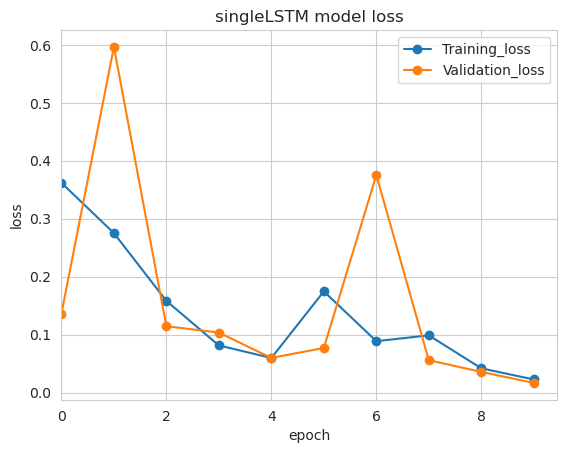

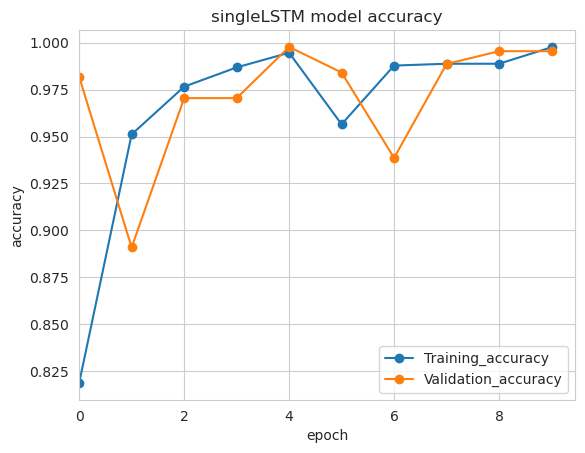

In [30]:
#plot the training and validation loss and accuracy
plot_loss_accuracy(history_1, 'singleLSTM')

In [35]:
# plot the tensorboard results
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# %tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

### Single LSTM layer with FastText embedding layer

In [ ]:
# build, train and evaluate the LSTM model
model_lstm_ft, history_lstm_ft, report_lstm_ft = build_train_singlelstm_model('singleLSTM_FT', X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

### Stacked LSTM layers


In [64]:
# write a function to build, train and evaluate the LSTM model
def build_train_stackedlstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate):
    
    # define the model architecture
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(LSTM(lstm_units_1, return_sequences=True))
    model.add(LSTM(lstm_units_2))
    model.add(Dropout(spa_dropout_ratio))
    # model.add(LSTM(lstm_units_1, dropout=dropout_ratio, recurrent_dropout=dropout_ratio))
    model.add(Dropout(spa_dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/singleLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='min'
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    print(confusion_matrix(y_test, y_pred))
        
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [65]:
# build, train and evaluate the double LSTM layers model
model_2, history_2, report_2 = build_train_doublelstm_model('doubleLSTM', X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 4715, 300)         10153200  
                                                                 
 lstm_3 (LSTM)               (None, 4715, 64)          93440     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10259089 (39.14 MB)
Trainable params: 10

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 42s 561ms/step - loss: 0.3237 - accuracy: 0.8705 - val_loss: 0.0481 - val_accuracy: 0.9955
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9878
Epoch 2: val_accuracy improved from 0.99545 to 0.97955, saving model to models/singleLSTM_20240127_032359.h5
64/64 [==============================] - 35s 540ms/step - loss: 0.0642 - accuracy: 0.9878 - val_loss: 0.0922 - val_accuracy: 0.9795
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9976
Epoch 3: val_accuracy did not improve from 0.97955
64/64 [==============================] - 33s 524ms/step - loss: 0.0216 - accuracy: 0.9976 - val_loss: 0.0182 - val_accuracy: 0.9977
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.9101
Epoch 4: val_accuracy improved from 0.97955 to 0.46818, saving model to models/singleLSTM_20240127_032359.h5
64/64 [==============================] - 33s 524ms/st

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
singleLSTM,0.995215,1.000000,0.990476,0.997727,187.598633
doubleLSTM,0.981132,0.971963,0.990476,0.990909,210.975855


#### Plot the results

[0.997, 0.991, 0.994]
[0.972, 0.9905, 0.9811]
plotMat: [[0.997, 0.991, 0.994], [0.972, 0.9905, 0.9811]]
support: [335, 105]


TypeError: Only length-1 arrays can be converted to Python scalars

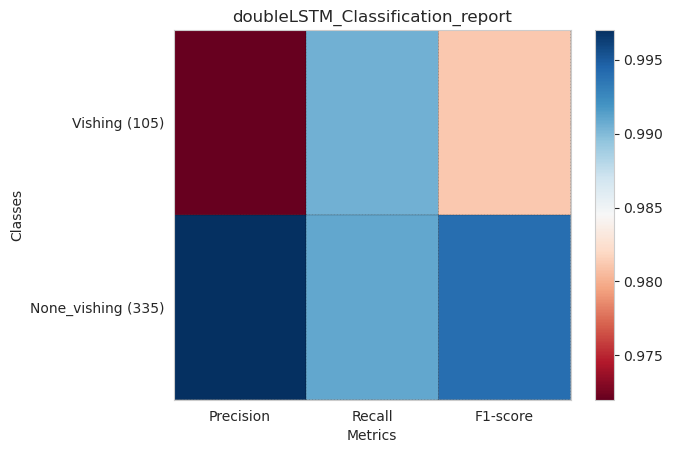

In [67]:
plot_classification_report(report_2, 'doubleLSTM_Classification_report')

In [29]:
#plot the training and validation loss and accuracy
plot_loss_accuracy(history_2, 'doubleLSTM')

NameError: name 'history_2' is not defined

In [ ]:
# write a function to build, train and evaluate the model
def build_model(model_name, embedding_layer, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate):
    # define the model
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(2, activation='softmax'))
    
    # compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps), loss='binary_crossentropy', metrics=['accuracy'])
    
    # print the model summary
    print(model.summary())
    
    # train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)
    end_time = time.time()
    training_time = end_time - start_time
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    
    # print the classification report
    print(classification_report(y_test, y_pred))
    
    # print the confusion matrix
    print(confusion_matrix(y_test, y_pred))
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # save the model
    model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]
    
    return model, history
